# Modelo de Procesamiento de Datos de Audio

Autores:

- Juan Diego Díaz Guzmán
- Juan Carlos Cerón Lombana
- Juan Sebastian Cely Bottía
    
## Introducción

El modelo consiste en la captura y el procesamiento de datos de audio a partir de un dispositivo móvil para desarrollar un modelo de inteligencia artificial con capacidades de clasificación.

## Marco Teórico

- Espectrograma: es una representación visual que permite identificar las diferentes variaciones de la frecuencia y la intensidad del sonido a lo largo de un periodo de tiempo. (UNIR Ecuador, 2024)
- Red neuronal: una red neuronal es un modelo de computación cuya estructura de capas se asemeja a la estructura interconectada de las neuronas en el cerebro, con capas de nodos conectados. Una red neuronal puede aprender de los datos, de manera que se puede entrenar para que reconozca patrones, clasifique datos y pronostique eventos futuros. (MathWorks, 2024)
- Red convolucional: es un tipo de red neuronal artificial diseñada para procesar datos con una topología en forma de cuadrícula, como datos de series temporales o de imágenes. Son especialmente útiles en tareas de visión por ordenador como la clasificación de imágenes, la detección de objetos y la segmentación semántica, debido a su capacidad para aprender y extraer características relevantes de los datos de forma automática. (LeCun _et al._, 1989) 

## Descripción del problema a solucionar

Se pretende desarrollar un modelo de inteligencia artificial mediante redes neuronales que sea capaz de clasificar correctamente datos de audio con voces para las palabras: corriendo, caminando, reposo, arriba, abajo, ola, izquierda y derecha. Se pretende entrenar el modelo con audios etiquetados y comprobar su precisión mediante métricas establecidas. 

## Planteamiento de la solución

In [1]:
# importación de librerías
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Carga de los datos

In [2]:
# Función de carga para archivos de audio en canal mono
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename) # Carga de archivo .wav
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # Decodificación wav (tensores por canales)    
    wav = tf.squeeze(wav, axis=-1) # Removiendo eje final    
    return wav # Devuelve archivo como vector numpy

### Carga de muestra de audio 

In [3]:
# Definición de ruta para archivos de audio
PATH = "../data/audio/corriendo-jc (1).wav"
wave = load_wav_16k_mono(PATH) # Carga de audio de muestra
print(wave.shape) # Dimensiones del audio
display.display(display.Audio(wave, rate=16000)) # Reproducción del audio 

(17600,)


In [4]:
# Función para generar espectrograma a partir de las muestras de audio.
def preprocess(wave):
    wav = wave[:16000] 
    spectrogram = tf.signal.stft(wav, frame_length=255, frame_step=128) # transformada de Fourier para conversión de datos
    spectrogram = tf.abs(spectrogram) # valores absolutos de la transformada
    return spectrogram

In [5]:
# Prueba de la función para espectrograma
espectrograma = preprocess(wave)
print("Waveform shape:", wave.shape)
print("Spectrogram shape:", espectrograma.shape)

Waveform shape: (17600,)
Spectrogram shape: (124, 129)


In [6]:
"""
Función para graficar el espectrograma.
Convierte las frecuencias a una escala logarítmica 
de manera que el tiempo se representa en el eje x (columnas).
"""

def plot_spectrogram(espectrograma, ax):
  # conversión a escala logarítmica
  log_spec = np.log(espectrograma.T)
  # dimensiones de los datos
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  # dimensiones de la gráfica 
  X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
  Y = range(height)
  # almacenamiento del plot en el eje
  ax.pcolormesh(X, Y, log_spec)

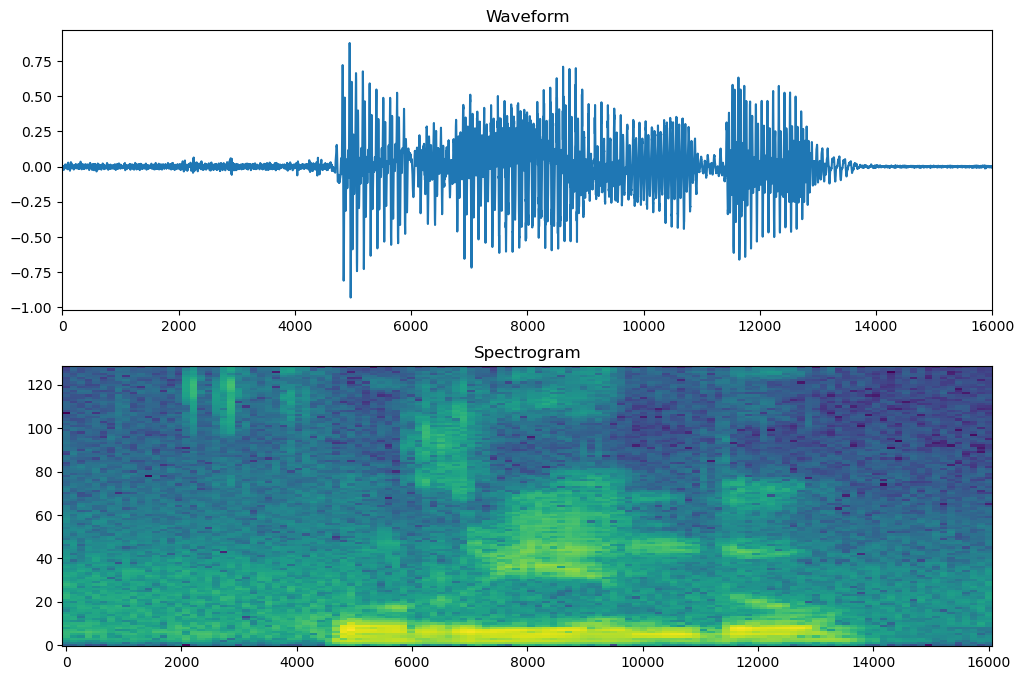

In [7]:
"""
Gráfica del primer audio de prueba, se establecen 2 subplots. 
El primer subplot es para la gráfica de frecuencias
El segundo subplot es para el espectrograma
"""

fig, axes = plt.subplots(2, figsize=(12, 8))
# Se establece la escala temporal en periodos fijos
timescale = np.arange(wave.shape[0])
# configuración de los parámetros del plot
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(espectrograma.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

### Carga de audios por lote

Se cargan los datos de audio y se definen las características X y las clases de la variable objetivo Y. 

In [11]:
import os
"""
Función para crear una lista con los nombres de archivo 
de audio presentes en la ruta especificada. Además, se 
extrae la clase de cada audio.
"""

def listFiles(path):
    audioFiles = []
    targets = []
    for fileName in os.listdir(path):
        audioFiles.append(fileName)
        targets.append(fileName.split("-")[0])
    return audioFiles, targets

# Carga de los archivos de audio
path = "../data/audio" 
archivos, Y = listFiles(path)
print(len(archivos))
print(len(Y))

90
90


In [12]:
# Arreglo de espectrogramas de lso audios
X = np.zeros((len(archivos), 124, 129))

# Carga y generación de espectrogramas de cada archivo de audio
for i, archivo in enumerate(archivos):
    wave = load_wav_16k_mono(f'{path}/{archivo}')
    espectrograma = preprocess(wave)
    X[i,:,:] = espectrograma

print(X.shape)

# Expansión de la variable a 4 dimensiones para procesarla con el modelo
X = np.expand_dims(X, axis=3)
print(X.shape)

(90, 124, 129)
(90, 124, 129, 1)


In [13]:
# Codificación de la variable objetivo
encoder = LabelEncoder()
encoder.fit(Y)
Y_encoded = encoder.transform(Y)
Y_encoded = keras.utils.to_categorical(Y_encoded)
Y_encoded.shape

(90, 6)

In [14]:
# Separación del conjunto de entrenamiento y de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size = 0.2, random_state = 0)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Comprobación de dimensiones
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (72, 124, 129, 1)
X_test shape: (18, 124, 129, 1)
y_train shape: (72, 6)
y_test shape: (18, 6)


### Definición y entrenamiento de la red neuronal

#### Modelo 1



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 129, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 129, 16)      1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 129, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 129, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 65, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 257920)            0         
                                                      

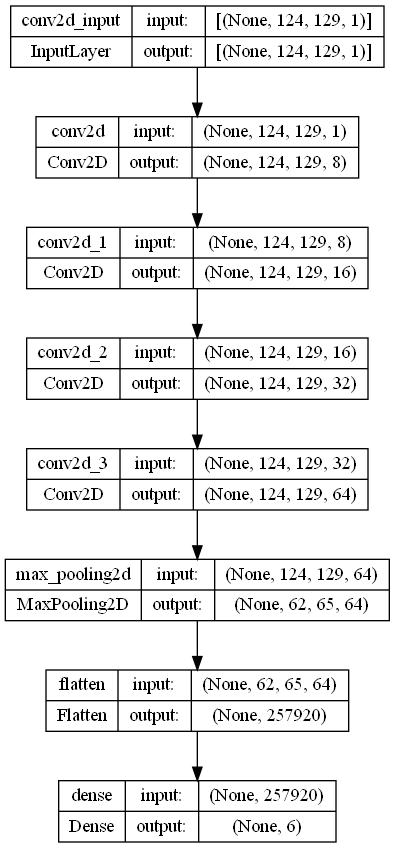

In [15]:
# Número de clases de salida para la red neuronal
n_clases = len(np.unique(Y))

# Definición del modelo secuencial de la red neuronal
modelo1 = keras.models.Sequential()
modelo1.add(keras.layers.Conv2D(8, 3, activation="relu",padding="same", input_shape=(124,129,1)))
modelo1.add(keras.layers.Conv2D(16, 3, activation="relu",padding="same"))
modelo1.add(keras.layers.Conv2D(32, 3, activation="relu",padding="same"))
modelo1.add(keras.layers.Conv2D(64, 3, activation="relu",padding="same"))
modelo1.add(keras.layers.MaxPooling2D(pool_size=2,strides=2, padding='same'))
modelo1.add(keras.layers.Flatten())
modelo1.add(keras.layers.Dense(n_clases, activation = 'softmax'))

modelo1.summary()
keras.utils.plot_model(modelo1, to_file='audio_model1_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
# Compilación y entrenamiento del modelo neuronal
modelo1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
historia1 = modelo1.fit(X_train, y_train, epochs=8,batch_size=None)

Epoch 1/8


3/3 [==============================] - 6s 1s/step - loss: 1.7474 - accuracy: 0.2778
Epoch 2/8
3/3 [==============================] - 2s 550ms/step - loss: 0.5385 - accuracy: 0.9028
Epoch 3/8
3/3 [==============================] - 2s 475ms/step - loss: 0.1518 - accuracy: 0.9722
Epoch 4/8
3/3 [==============================] - 2s 469ms/step - loss: 0.0194 - accuracy: 1.0000
Epoch 5/8
3/3 [==============================] - 2s 477ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 6/8
3/3 [==============================] - 2s 451ms/step - loss: 4.4814e-04 - accuracy: 1.0000
Epoch 7/8
3/3 [==============================] - 2s 520ms/step - loss: 3.9218e-05 - accuracy: 1.0000
Epoch 8/8
3/3 [==============================] - 2s 527ms/step - loss: 9.7847e-06 - accuracy: 1.0000


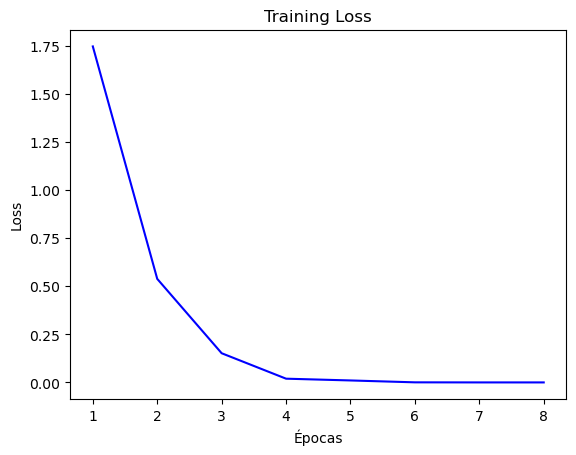

In [17]:
# Gráfico de la pérdida de entrenamiento
loss_train1 = historia1.history['loss']
epocas1 = range(1, len(loss_train1) + 1)

plt.plot(epocas1, loss_train1, 'b')
plt.title('Training Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.show()

In [18]:
modelo1.evaluate(X_test, y_test)

1/1 [==============================] - 1s 572ms/step - loss: 0.1248 - accuracy: 0.9444


[0.12476566433906555, 0.9444444179534912]

1/1 [==============================] - 0s 282ms/step
              precision    recall  f1-score   support

       abajo       1.00      0.75      0.86         4
      arriba       1.00      1.00      1.00         3
   caminando       1.00      1.00      1.00         4
   corriendo       1.00      1.00      1.00         3
     derecha       0.67      1.00      0.80         2
   izquierda       1.00      1.00      1.00         2

    accuracy                           0.94        18
   macro avg       0.94      0.96      0.94        18
weighted avg       0.96      0.94      0.95        18

[[3 0 0 0 1 0]
 [0 3 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 2]]


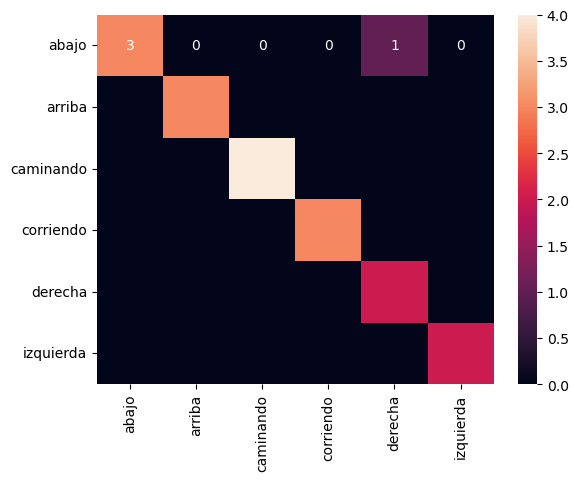

In [19]:
# Calculo de la métricas de precisión y matriz de confusión
y_pred = modelo1.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

categorias = np.unique(Y)
y_test_class = encoder.inverse_transform(y_test_class)
y_pred_class = encoder.inverse_transform(y_pred_class)

# Accuracy of the predicted values
print(
    classification_report(y_test_class, y_pred_class)
)  # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)

# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(
    df_cm, annot=True, fmt="d", xticklabels=categorias, yticklabels=categorias
)

#### Modelo 2

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 129, 16)      160       
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 129, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 65, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 128960)            0         
                                                                 
 dense_1 (Dense)             (None, 6)                 773766    
                                                                 
Total params: 778566 (2.97 MB)
Trainable params: 778566 (2.97 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

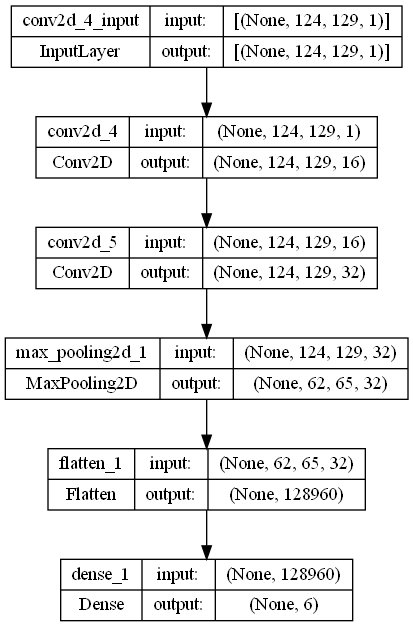

In [20]:
# Número de clases de salida para la red neuronal
n_clases = len(np.unique(Y))

# Definición del modelo secuencial de la red neuronal
modelo2 = keras.models.Sequential()
modelo2.add(keras.layers.Conv2D(16, 3, activation="relu",padding="same", input_shape=(124,129,1)))
modelo2.add(keras.layers.Conv2D(32, 3, activation="relu",padding="same"))
modelo2.add(keras.layers.MaxPooling2D(pool_size=2,strides=2, padding='same'))
modelo2.add(keras.layers.Flatten())
modelo2.add(keras.layers.Dense(n_clases, activation = 'softmax'))

modelo2.summary()
keras.utils.plot_model(modelo2, to_file='audio_model2_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
# Compilación y entrenamiento del modelo neuronal
modelo2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
historia2 = modelo2.fit(X_train, y_train, epochs=6,batch_size=None)

Epoch 1/6
3/3 [==============================] - 2s 183ms/step - loss: 2.0581 - accuracy: 0.3333
Epoch 2/6
3/3 [==============================] - 0s 126ms/step - loss: 0.5731 - accuracy: 0.8750
Epoch 3/6
3/3 [==============================] - 0s 130ms/step - loss: 0.2500 - accuracy: 0.9167
Epoch 4/6
3/3 [==============================] - 0s 127ms/step - loss: 0.0504 - accuracy: 1.0000
Epoch 5/6
3/3 [==============================] - 0s 129ms/step - loss: 0.0430 - accuracy: 0.9861
Epoch 6/6
3/3 [==============================] - 0s 131ms/step - loss: 0.0138 - accuracy: 1.0000


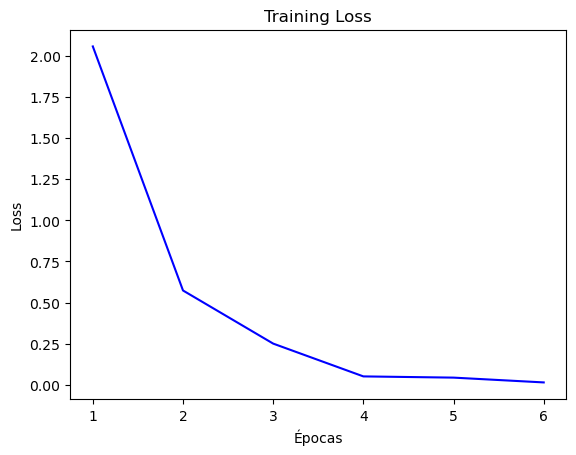

In [22]:
# Gráfico de la pérdida de entrenamiento
loss_train2 = historia2.history['loss']
epocas2 = range(1, len(loss_train2) + 1)

plt.plot(epocas2, loss_train2, 'b')
plt.title('Training Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.show()

In [23]:
modelo2.evaluate(X_test, y_test)

1/1 [==============================] - 0s 281ms/step - loss: 0.0749 - accuracy: 1.0000


[0.07493255287408829, 1.0]

1/1 [==============================] - 0s 162ms/step
              precision    recall  f1-score   support

       abajo       1.00      1.00      1.00         4
      arriba       1.00      1.00      1.00         3
   caminando       1.00      1.00      1.00         4
   corriendo       1.00      1.00      1.00         3
     derecha       1.00      1.00      1.00         2
   izquierda       1.00      1.00      1.00         2

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 2]]


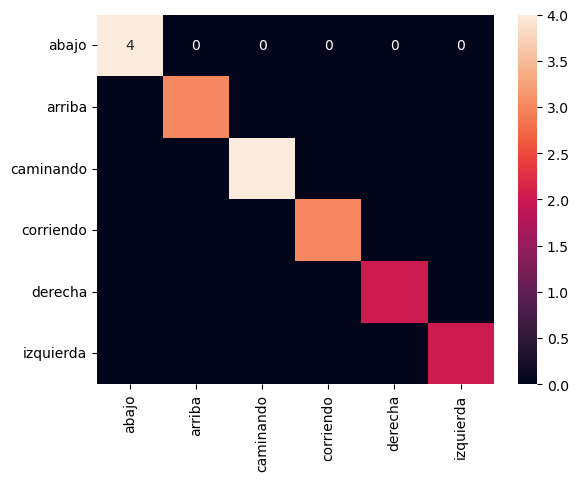

In [24]:
# Calculo de la métricas de precisión y matriz de confusión
y_pred = modelo2.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

categorias = np.unique(Y)
y_test_class = encoder.inverse_transform(y_test_class)
y_pred_class = encoder.inverse_transform(y_pred_class)

# Accuracy of the predicted values
print(
    classification_report(y_test_class, y_pred_class)
)  # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)

# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(
    df_cm, annot=True, fmt="d", xticklabels=categorias, yticklabels=categorias
)

## Resultados

De acuerdo con los resultados obtenidos, se puede concluir que:

- Los dos modelos alcanzan buenos resultados luego del entrenamiento, logrando una alta precisión en la etapa de entrenamiento entre 5 y 10 épocas. 
- El primer modelo no llega a generalizar muy bien con pocas épocas, pero con más épocas se logra una mayor precisión.Sin embargo, la cantidad de capas y el número de nodos por capa exigen un mayor uso de capacidad computacional. 
- El segundo modelo llega a generalizar más rápido que el primero, además de que al contar con menos capas en la red y más nodos por capa, es más eficiente en el uso de la capacidad computacional.

## Referencias

_UNIR Ecuador. (2024, March 31). ¿Qué es el espectrograma y cuáles son sus usos en el análisis musical?. UNIR. https://ecuador.unir.net/actualidad-unir/espectrograma/_

_MathWorks. (2024, March 30). ¿Qué es una red neuronal?. https://la.mathworks.com/discovery/neural-network.html_

_Yann LeCun, Bernhard Boser, John S Denker, Donnie Henderson, Richard E Howard, Wayne Hubbard, and Lawrence D Jackel. Backpropagation applied to handwritten zip code recognition. Neural computation, 1(4):541–551, 1989._